<br><br><br><br>
<h1>03. Analyzing and managing my portfolio</h1>

<p>Or something</p>

<br><br><br><br>
<h2>0. Document setup</h2>

In [1]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))



import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from typing import Dict, Union, Optional
from scipy.stats import kendalltau, spearmanr, kstest, uniform, norm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import t as tdist
from scipy.special import gammaln
from scipy.optimize import minimize_scalar, minimize
from dataclasses import dataclass
from typing import Callable, Dict, Any, Optional, Sequence, Tuple
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from scipy.stats import multivariate_normal, multivariate_t






from src.data_handlers.yfinance_data_loader import load_prices, load_prices_many
from src.utils.visualization import plot_price_overview
from src.utils.data_handlers import compute_log_returns
from src.utils.visualization import plot_log_returns_overview
from src.utils.visualization import plot_acf_scaled_grid
from src.data_handlers.yfinance_data_loader import load_prices_many
from src.utils.data_handlers import mean_tests_for_assets
from src.utils.data_handlers import fit_vol_models_many_assets, select_best_models, extract_vol_and_std_resid
from src.utils.visualization import plot_vol_and_resid_grid
from src.utils.data_handlers import compute_corr_matrices
from src.utils.visualization import plot_corr_heatmaps
from src.utils.portfolio_analysis import compute_markowitz_points_with_rf
from src.utils.visualization import plot_return_vs_risk
from src.utils.data_handlers import dict_series_to_panel
from src.utils.portfolio_analysis import compute_windowed_markowitz_garch, flatten_window_points
from src.utils.visualization import plot_return_vs_risk_progression







<br><br><br><br>
<h3>Portfolio config.</h3>

In [2]:
START = "2020-01-01"
END   = "2025-12-01"

# Your tickers (must match columns in log_returns)
TICKERS = ["INVE-B.ST", "BRK-B", "SPGI", "0P0000YVZ3.ST", "0P0000ULAP.ST"]


# Portfolio weights (same order as TICKERS). Must sum to 1.
WEIGHTS = {
    "BRK-B": 0.231,
    "INVE-B.ST": 0.285,
    "SPGI": 0.199,
    "0P0000YVZ3.ST": 0.219,   # Länsförsäkringar Global Index
    "0P0000ULAP.ST": 0.066,   # Spiltan Aktiefond Investmentbolag
} # sums to 0.90 -> rf weight becomes 0.10


# Risk-free (fixed-rate account) annual rate (as decimal, e.g. 0.03 = 3%)
RF_ANNUAL = 0.013

# Sampling assumptions for annualization
TRADING_DAYS = 252

<br><br><br><br>
<h2>1. Data preparation</h2>

In [3]:
tickers = TICKERS

raw_prices = load_prices_many(tickers, START, END)
list(raw_prices.keys()), {k: v.shape for k, v in raw_prices.items()}

[1/5] Loading INVE-B.ST...
  -> ok: 1490 rows, 5 cols
[2/5] Loading BRK-B...
  -> ok: 1486 rows, 5 cols
[3/5] Loading SPGI...
  -> ok: 1486 rows, 5 cols
[4/5] Loading 0P0000YVZ3.ST...
  -> ok: 890 rows, 5 cols
[5/5] Loading 0P0000ULAP.ST...
  -> ok: 858 rows, 5 cols


(['INVE-B.ST', 'BRK-B', 'SPGI', '0P0000YVZ3.ST', '0P0000ULAP.ST'],
 {'INVE-B.ST': (1490, 5),
  'BRK-B': (1486, 5),
  'SPGI': (1486, 5),
  '0P0000YVZ3.ST': (890, 5),
  '0P0000ULAP.ST': (858, 5)})

<br><br><br><br>
<h3>Price plots</h3>

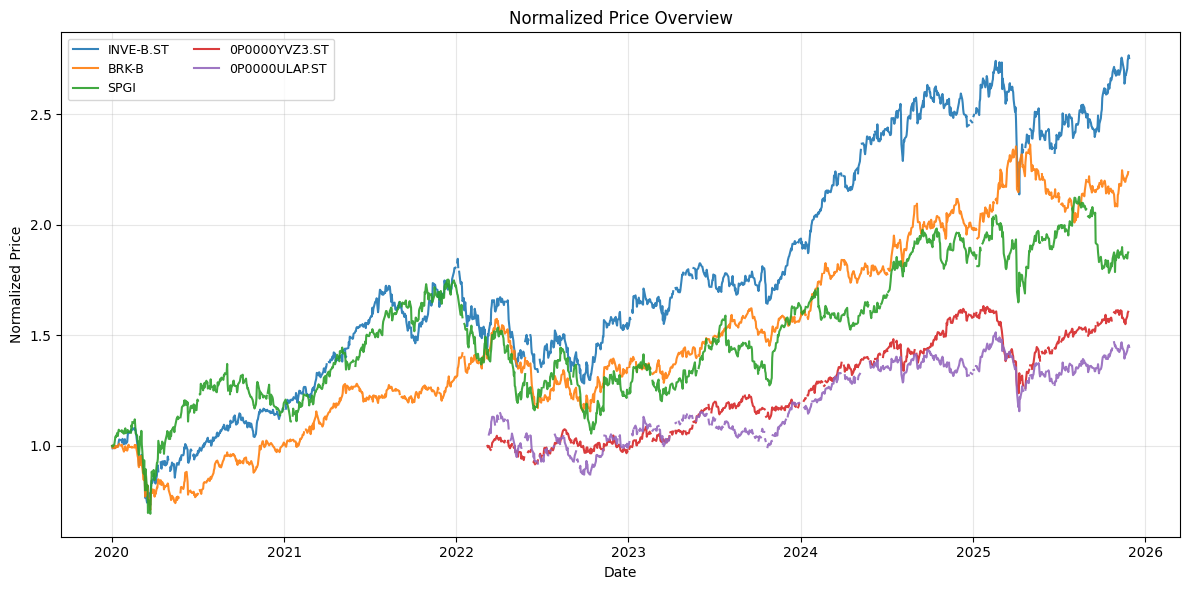

In [4]:
price_panel = plot_price_overview(raw_prices)

<br><br><br><br>
<h3>Transform to log returns and plot</h3>

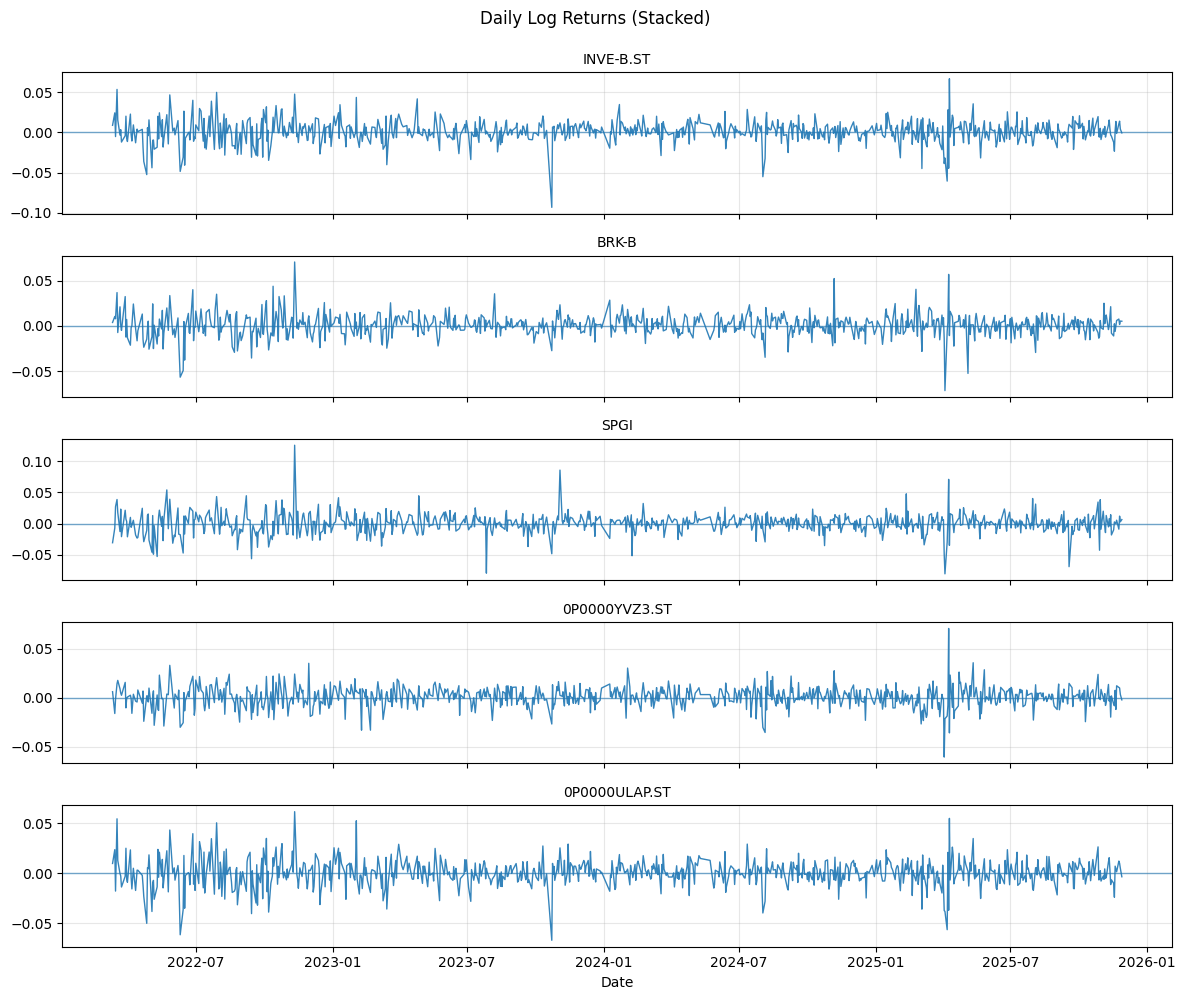

,INVE-B.ST,BRK-B,SPGI,0P0000YVZ3.ST,0P0000ULAP.ST
2022-03-11,0.008809,0.003681,-0.030682,0.006014,0.009924
2022-03-14,0.024341,0.010296,-0.007084,-0.016173,0.023737
2022-03-15,-0.005210,0.007758,0.027187,-0.001739,-0.017734
2022-03-17,0.053544,0.036667,0.038661,0.014106,0.054645
2022-03-18,0.015415,-0.007449,0.017918,0.017537,0.012957
...,...,...,...,...,...
2025-11-21,-0.001279,0.005810,0.005465,0.012065,0.001590
2025-11-24,0.010663,0.007452,-0.008872,0.010484,0.012322
2025-11-25,0.013991,0.001496,0.012031,0.009823,0.010002
2025-11-26,0.004051,0.005217,0.002869,0.003223,0.005068


In [5]:
log_returns = compute_log_returns(raw_prices, join="inner", dropna="any")


plot_log_returns_overview(
    log_returns,
    title="Daily Log Returns (Stacked)",
    figsize=(12, 10),
)




<br><br><br><br>
<h2>2. Time series analysis</h2>

<br><br><br><br>
<h3>ACF and Absolute ACF for log returns</h3>

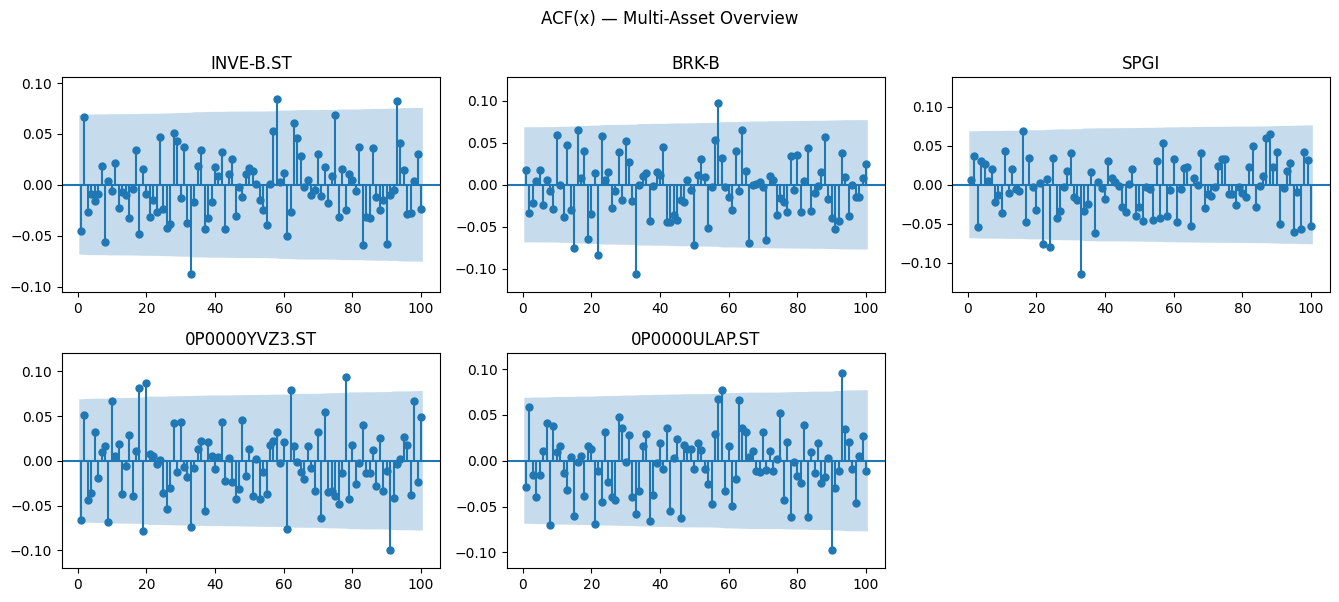

In [6]:


plot_acf_scaled_grid(
    log_returns,
    lags=100,
    conf_level=0.95,
    cols=3,
    max_assets=12,   # optional safeguard
)


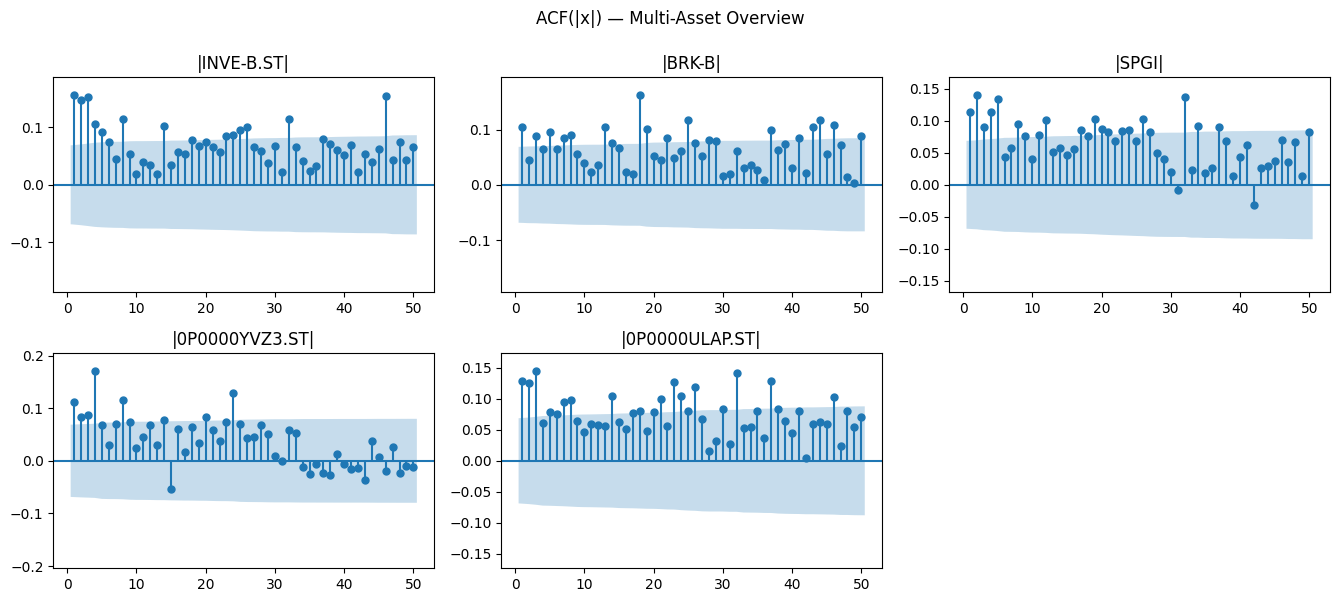

In [7]:
plot_acf_scaled_grid(log_returns, lags=50, cols=3, abs_series=True)


<br><br><br><br>
<h3>Fitting a volatility model</h3>

<br><br><br><br>
Validating that mean function is indeed constant zero.

In [8]:
mean_tests_for_assets(log_returns)


,Estimate,Std. Error,t-stat,p-value,N
Asset,,,,,
0P0000ULAP.ST,0.000405,0.000468,0.864574,0.387527,815.0
0P0000YVZ3.ST,0.000587,0.000371,1.582486,0.113927,815.0
BRK-B,0.000560,0.000425,1.319722,0.187299,815.0
INVE-B.ST,0.000741,0.000487,1.520172,0.128856,815.0
SPGI,0.000336,0.000561,0.599600,0.548940,815.0


<br><br><br><br>
Fitting volatility models by grid search.

In [9]:
results_all, fitted_all = fit_vol_models_many_assets(
    log_returns,
    mean="Constant",      # or "Zero" if you want strict
    ljungbox_lags=10,
)
results_all.head(20)


/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/.venv/lib/python3.13/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001932. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/.venv/lib/python3.13/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001932. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializ

,Asset,Model,Dist,AIC,BIC,LB(z) pval,LB(|z|) pval,LB(z^2) pval,alpha+beta
0,0P0000ULAP.ST,"GARCH(1,1)",normal,-4813.566071,-4794.753319,0.276817,8.423874e-01,7.735704e-01,0.980000
1,0P0000ULAP.ST,"GARCH(1,2)",normal,-4811.261994,-4787.746054,0.224310,7.913775e-01,6.654276e-01,0.515000
2,0P0000ULAP.ST,"GARCH(2,1)",normal,-4808.974472,-4785.458531,0.291447,6.507585e-01,5.882090e-01,0.955000
3,0P0000ULAP.ST,ARCH(3),normal,-4768.462082,-4744.946142,0.101870,4.567830e-01,9.872113e-02,NaN
4,0P0000ULAP.ST,ARCH(2),normal,-4764.010488,-4745.197735,0.072310,5.845591e-02,5.536663e-02,NaN
5,0P0000ULAP.ST,ARCH(1),normal,-4742.137239,-4728.027674,0.171103,9.203224e-05,1.861935e-02,NaN
6,0P0000ULAP.ST,ARCH(1),t,-3904.159460,-3885.346708,0.184607,2.694874e-05,1.032368e-02,NaN
7,0P0000ULAP.ST,ARCH(2),t,-3872.710674,-3849.194733,0.220470,4.230031e-05,3.223331e-03,NaN
8,0P0000ULAP.ST,"GARCH(2,1)",t,-3815.598942,-3787.379813,0.230194,2.019606e-01,9.791420e-02,0.635996
9,0P0000ULAP.ST,ARCH(3),t,-3704.309160,-3676.090031,0.201854,6.325193e-06,6.045310e-03,NaN


<br><br><br><br>
Selecting best model for each asset.

In [10]:
best = select_best_models(results_all, by="AIC")
best


,Model,Dist,AIC,BIC,LB(z) pval,LB(|z|) pval,LB(z^2) pval,alpha+beta
Asset,,,,,,,,
0P0000ULAP.ST,"GARCH(1,1)",normal,-4813.566071,-4794.753319,0.276817,0.842387,0.773570,0.980000
0P0000YVZ3.ST,"GARCH(1,1)",normal,-5160.639429,-5141.826676,0.229510,0.549554,0.002338,0.979999
BRK-B,"GARCH(1,2)",normal,-4947.540090,-4924.024150,0.824128,0.983068,0.973021,0.514993
INVE-B.ST,"GARCH(1,1)",t,-4821.834676,-4798.318735,0.859889,0.877996,0.992839,0.900502
SPGI,"GARCH(1,2)",normal,-4468.382399,-4444.866459,0.937962,0.617041,0.991339,0.515000


<br><br><br><br>
Extracting volatility model per asset.

In [11]:
vol_by_asset, z_by_asset = extract_vol_and_std_resid(fitted_all, best)


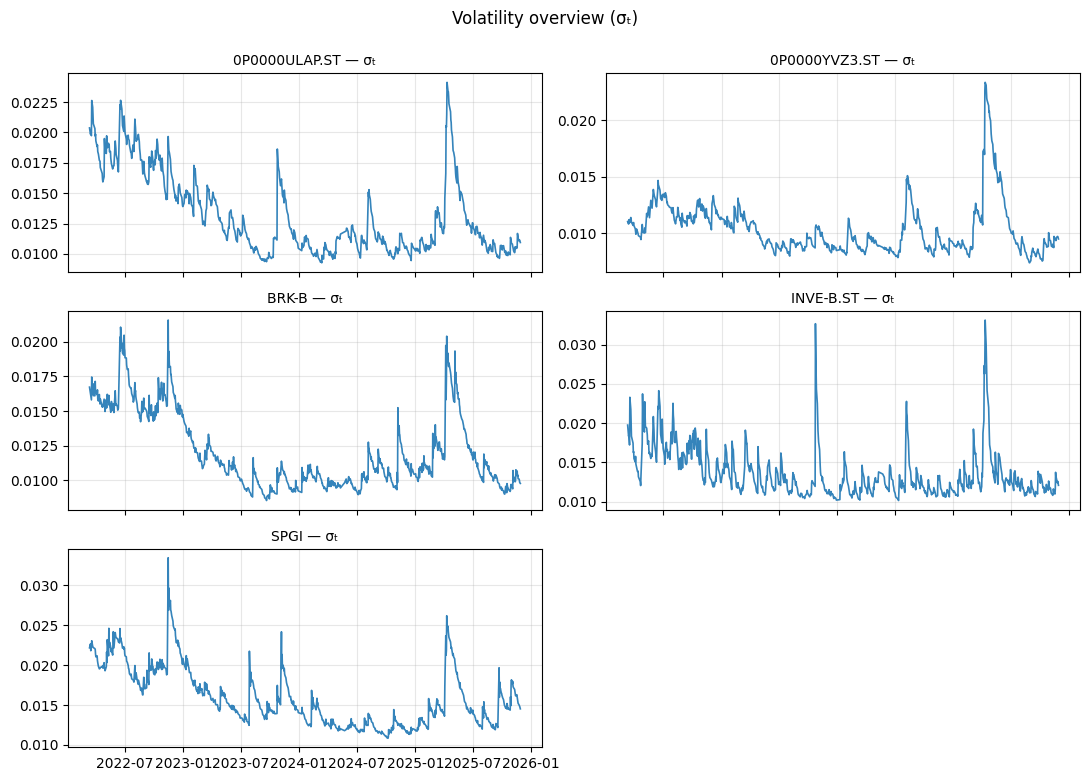

In [12]:


plot_vol_and_resid_grid(
    vol_by_asset,
    show_resid=False,
    cols=2,
    max_assets=12,
    title="Volatility overview (σₜ)",
)


<br><br><br><br>
<h2>3. Portfolio analysis on log returns</h2>

<br><br><br><br>
<h3>Correlation measures between assets</h3>

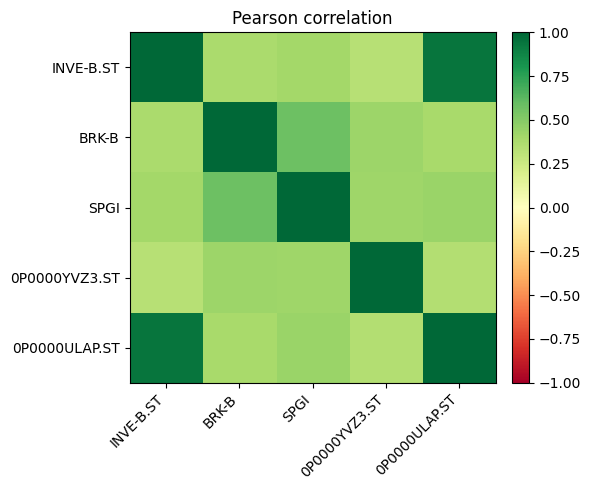

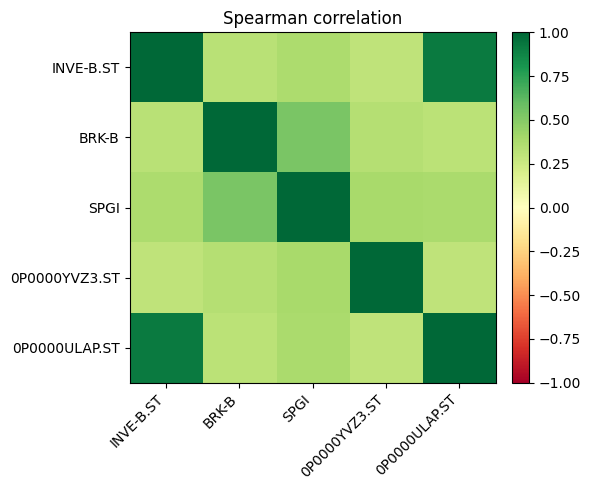

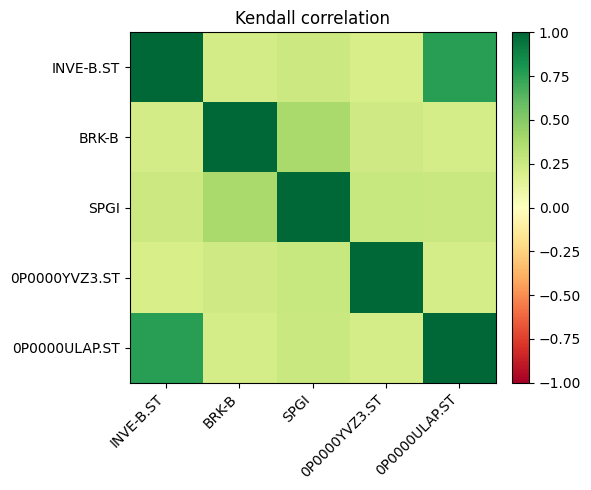

In [13]:
corrs = compute_corr_matrices(log_returns, min_periods=250)

plot_corr_heatmaps(
    corrs.pearson,
    corrs.spearman,
    corrs.kendall,
    figsize=(6, 5),
    annot=False,  # True only if small N
)

<br><br><br><br>
<h3>Calculating Markowitz points</h3>

In [14]:


# log_returns already computed earlier from your raw_prices
res = compute_markowitz_points_with_rf(
    log_returns[TICKERS],
    WEIGHTS,
    rf_annual=RF_ANNUAL,
    start=START,
    end=END,
    trading_days=TRADING_DAYS,
)



<br><br><br><br>
<h3>Risk vs. return for assets and portfolio</h3>

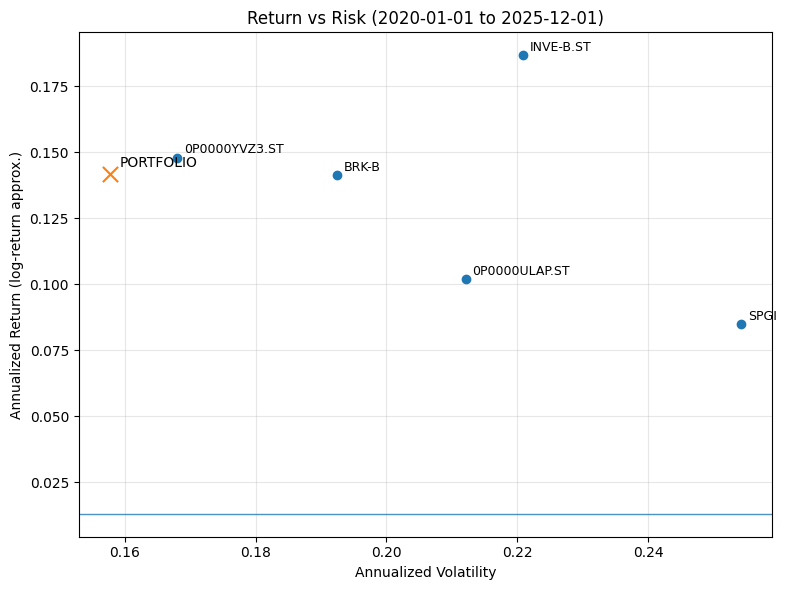

In [15]:
plot_return_vs_risk(
    res.points,
    rf_annual=RF_ANNUAL,
    title=f"Return vs Risk ({START} to {END})",
)


<br><br><br><br>
<h2>4. Portfolio analysis using fitted volatility models and residuals</h2>

In [16]:
sigma_panel = dict_series_to_panel(vol_by_asset, join="inner", start=START, end=END)
z_panel     = dict_series_to_panel(z_by_asset,   join="inner", start=START, end=END)

# returns panel aligned to same assets (and same period)
returns_panel = log_returns[sigma_panel.columns].copy()
returns_panel = returns_panel.loc[sigma_panel.index]  # align dates
returns_panel.shape, sigma_panel.shape, z_panel.shape

((815, 5), (815, 5), (815, 5))

<br><br><br><br>
<h3>Correlation of residuals</h3>

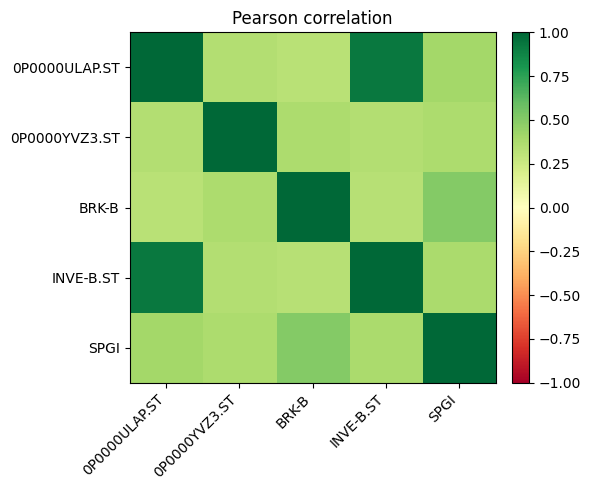

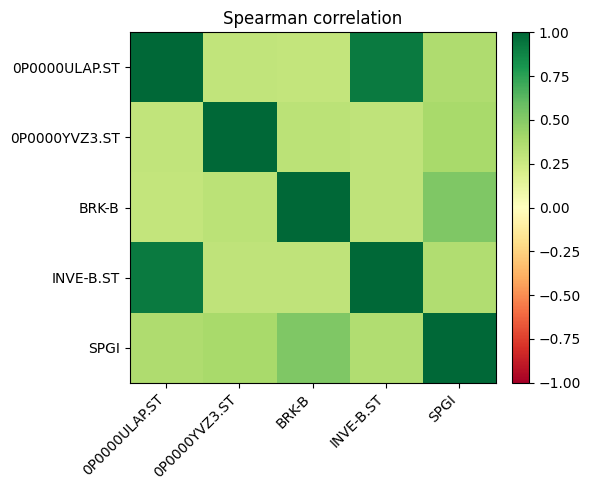

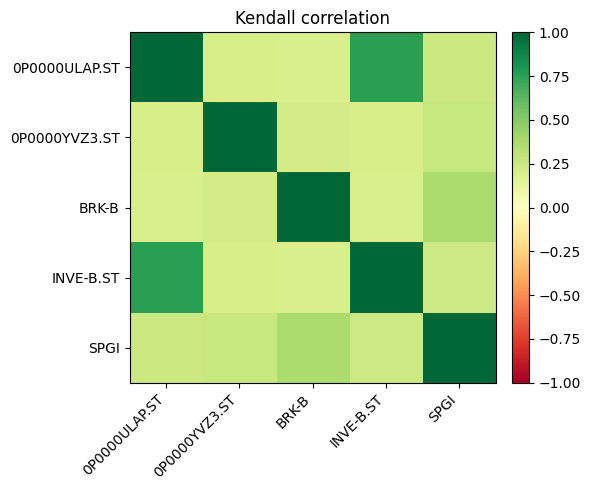

In [17]:
corrs_z = compute_corr_matrices(z_panel, min_periods=250)

plot_corr_heatmaps(
    corrs_z.pearson,
    corrs_z.spearman,
    corrs_z.kendall,
    figsize=(6, 5),
    annot=False,
)


<br><br><br><br>
<h3>Risk vs. return from fitted marginal distributions</h3>

In [24]:
window_outputs = compute_windowed_markowitz_garch(
    returns_panel=returns_panel,    # log returns; determines mean return (y-axis)
    sigma_panel=sigma_panel,        # conditional vols from GARCH; determines risk (x-axis)
    z_panel=z_panel,                # standardized residuals; used to estimate correlations
    weights=WEIGHTS,                # risky-asset weights; affects PORTFOLIO point only
    rf_annual=RF_ANNUAL,            # risk-free annual rate; shifts portfolio return vertically
    window_days=252*3,               # length of each estimation window (in trading days)
                                     # ↑ longer = smoother estimates, fewer points
    step_days=21,                    # step between windows (rebalancing frequency)
                                     # ↑ smaller = more overlap, smoother progression
    sigma_agg="mean",                # how to summarize σ_t in window:
                                     # "mean" = average risk over window
                                     # "last" = current/end-of-window risk
    corr_for_cov="pearson"           # which correlation of z_t to use in Σ = D R D
                                     # ("pearson", "spearman", "kendall")
)

points_long = flatten_window_points(window_outputs)  # long-form table for plotting
points_long.head()


,window_idx,start,end,asset,ann_return,ann_vol
0,0,2022-03-11,2025-09-02,0P0000ULAP.ST,0.082604,0.211795
1,0,2022-03-11,2025-09-02,0P0000YVZ3.ST,0.136972,0.166328
2,0,2022-03-11,2025-09-02,BRK-B,0.143943,0.193391
3,0,2022-03-11,2025-09-02,INVE-B.ST,0.160608,0.217760
4,0,2022-03-11,2025-09-02,SPGI,0.116923,0.251714


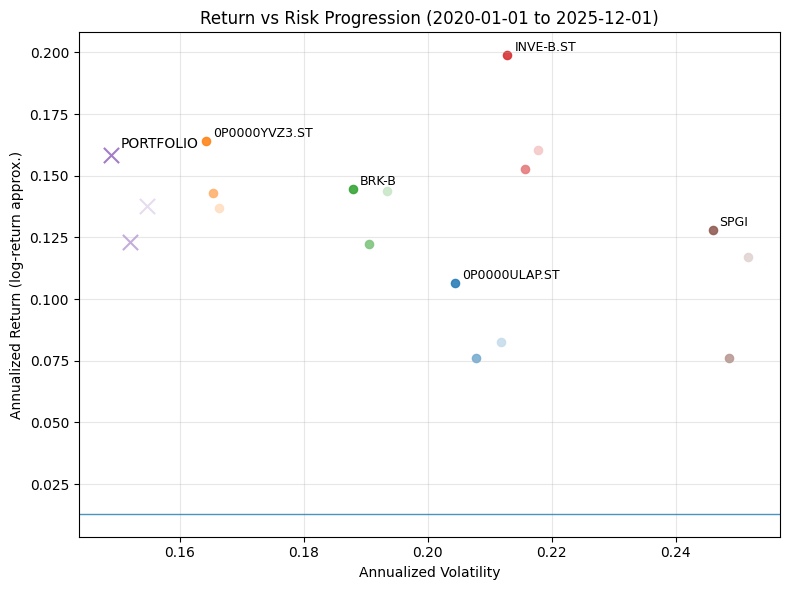

In [26]:
plot_return_vs_risk_progression(
    points_long,
    rf_annual=RF_ANNUAL,
    title=f"Return vs Risk Progression ({START} to {END})",
    plot_assets=True,
    plot_portfolio=True,
    annotate_last=True,
)


<br><br><br><br>
<h3>Yearly displayed risk vs. return from fitted marginal distributions</h3>

In [25]:
window_outputs = compute_windowed_markowitz_garch(
    returns_panel=returns_panel,    # log returns; determines mean return (y-axis)
    sigma_panel=sigma_panel,        # conditional vols from GARCH; determines risk (x-axis)
    z_panel=z_panel,                # standardized residuals; used to estimate correlations
    weights=WEIGHTS,                # risky-asset weights; affects PORTFOLIO point only
    rf_annual=RF_ANNUAL,            # risk-free annual rate; shifts portfolio return vertically
    window_days=252*3,               # length of each estimation window (in trading days)
                                     # ↑ longer = smoother estimates, fewer points
    step_days=21,                    # step between windows (rebalancing frequency)
                                     # ↑ smaller = more overlap, smoother progression
    sigma_agg="mean",                # how to summarize σ_t in window:
                                     # "mean" = average risk over window
                                     # "last" = current/end-of-window risk
    corr_for_cov="pearson"           # which correlation of z_t to use in Σ = D R D
                                     # ("pearson", "spearman", "kendall")
)

points_long = flatten_window_points(window_outputs)  # long-form table for plotting
points_long.head()


,window_idx,start,end,asset,ann_return,ann_vol
0,0,2022-03-11,2025-09-02,0P0000ULAP.ST,0.082604,0.211795
1,0,2022-03-11,2025-09-02,0P0000YVZ3.ST,0.136972,0.166328
2,0,2022-03-11,2025-09-02,BRK-B,0.143943,0.193391
3,0,2022-03-11,2025-09-02,INVE-B.ST,0.160608,0.217760
4,0,2022-03-11,2025-09-02,SPGI,0.116923,0.251714


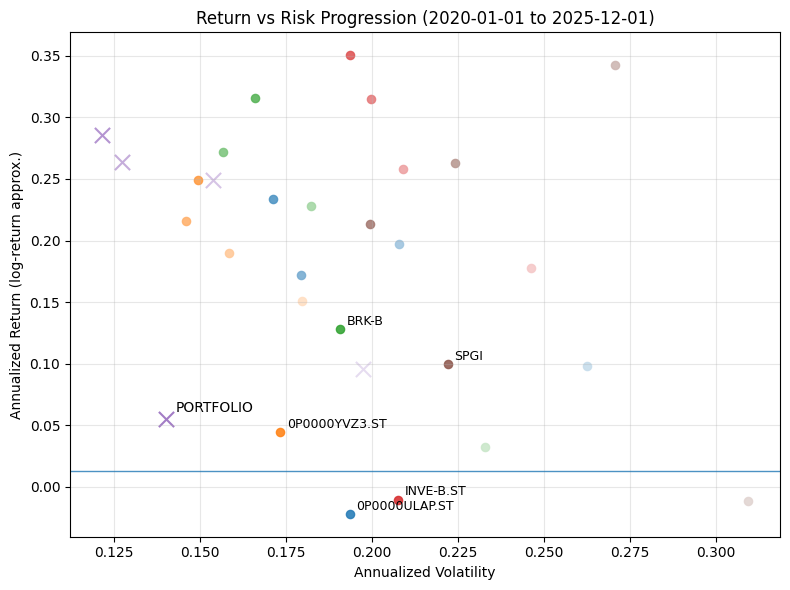

In [23]:
plot_return_vs_risk_progression(
    points_long,
    rf_annual=RF_ANNUAL,
    title=f"Return vs Risk Progression ({START} to {END})",
    plot_assets=True,
    plot_portfolio=True,
    annotate_last=True,
)
